# Model Exercises

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# wrangle
import acquire
import prepare as p

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt, ExponentialSmoothing

In [2]:

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

* The end result of this exercise should be a Jupyter notebook named model.

* Using saas.csv or log data from API usage or store_item_sales

In [3]:
saas_df = pd.read_csv('saas.csv')

In [4]:
saas_df

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...,...
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0


In [54]:
saas_df.Subscription_Type.nunique()

5

In [51]:
pd.crosstab(saas_df.Subscription_Type,saas_df.Amount)

Amount,0.0,5.0,10.0,15.0,20.0
Subscription_Type,,,,,
0.0,496410,0,0,0,0
1.0,0,178212,0,0,0
2.0,0,0,70706,0,0
3.0,0,0,0,26474,0
4.0,0,0,0,0,18656


In [53]:
saas_df.Customer_Id.nunique()

29400

In [5]:
saas_df = p.datetime_type(saas_df, 'Month_Invoiced')

In [6]:
saas_df = p.set_date_to_index(saas_df, 'Month_Invoiced')

In [7]:
saas_df.dtypes

Customer_Id            int64
Invoice_Id             int64
Subscription_Type    float64
Amount               float64
dtype: object

### 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [8]:
def human_based_split(end_train_time, start_test_time):
    train = df[:end_train_time]
    test = df[start_test_time]
    return train, test

In [9]:
def split_portion_method(df_resampled_target):
    train_size = int(round(df_resampled_target.shape[0] * 0.5))
    validate_size = int(round(df_resampled_target.shape[0] * 0.3))
    test_size = int(round(df_resampled_target.shape[0] * 0.2))
    
    validate_end_index = train_size + validate_size
    
    train = df_resampled_target[:train_size]
    
    validate = df_resampled_target[train_size:validate_end_index]
    
    test = df_resampled_target[validate_end_index:]
    
    return train, validate, test

df_resampled = df.resample('d')[['sale_amount','sales_total']].sum()
df_resampled.head()

In [10]:
monthly_saas_df = saas_df.resample('M')[['Amount']].sum()

In [11]:
train, validate, test = split_portion_method(monthly_saas_df)

In [12]:
train.shape, validate.shape, test.shape

((24, 1), (14, 1), (10, 1))

In [13]:
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(monthly_saas_df)

True

In [14]:
print(monthly_saas_df.head(1) == train.head(1))

                Amount
Month_Invoiced        
2014-01-31        True


In [15]:
pd.concat([train.tail(1), validate.head(1)])

,Amount
Month_Invoiced,
2015-12-31,51505.0
2016-01-31,51955.0


In [16]:
pd.concat([validate.tail(1), test.head(1)])

,Amount
Month_Invoiced,
2017-02-28,53440.0
2017-03-31,53480.0


In [17]:
pd.concat([test.tail(1), monthly_saas_df.tail(1)])

,Amount
Month_Invoiced,
2017-12-31,53805.0
2017-12-31,53805.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


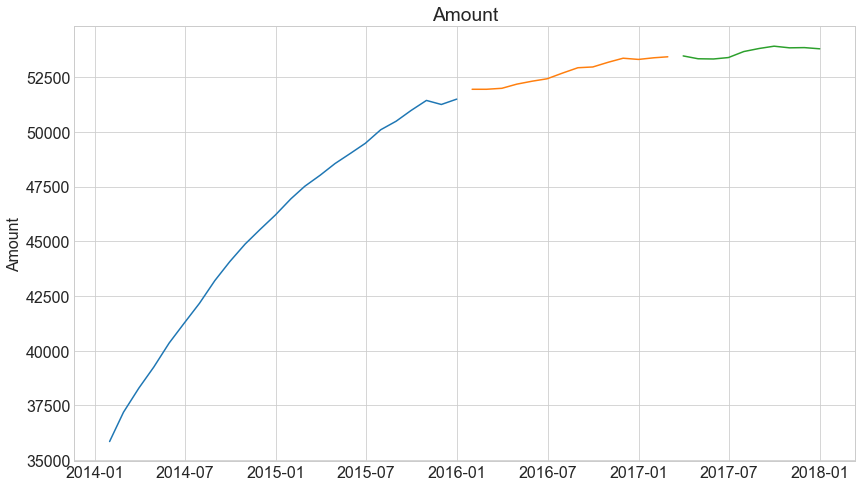

In [18]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.legend()
    plt.show()

### 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    * Simple Average
    * Moving Average
    * Holt's Linear Trend Model
    * Based on previous year/month/etc., this is up to you.

    
* Optional: Using store item demand

In [19]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [20]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    # set figure size
    plt.figure(figsize = (12,4))
    
    # plot target variable in train
    plt.plot(train[target_var], label='Train', linewidth=1)
    
    # plot target variable in validate
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    
    # plot yhat_df 'predictions' on target variable
    plt.plot(yhat_df[target_var], label = 'Prediction')
    
    #set title
    plt.title(target_var)
    
    # call on evaluate function to calculate rmse
    rmse = evaluate(target_var)
    
    #print
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.legend()
    plt.show()

In [21]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [22]:
def make_predictions(Amount=None):
    yhat_df = pd.DataFrame({'Amount': [Amount]},
                          index=validate.index)
    return yhat_df

In [23]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


### Last observed value

In [24]:
# take the last item of sales total and assign to variable
last_amount = train['Amount'][-1:][0]

In [25]:
yhat_df = pd.DataFrame(
    {'Amount': [last_amount],},
    index=validate.index)

yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0


In [26]:
yhat_df.describe()

,Amount
count,14.0
mean,51505.0
std,0.0
min,51505.0
25%,51505.0
50%,51505.0
75%,51505.0
max,51505.0


Amount -- RMSE: 1343


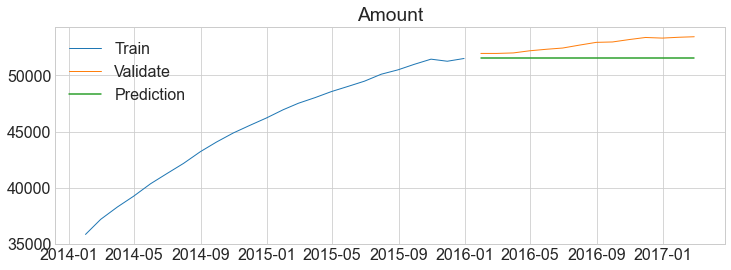

In [27]:
plot_and_eval('Amount')

In [28]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0


### Simple Average

In [29]:
# compute simple average
avg_amount = round(train['Amount'].mean(), 2)


In [30]:
yhat_df = make_predictions(avg_amount)

In [31]:
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


In [32]:
yhat_df.describe()

,Amount
count,1.400000e+01
mean,4.556854e+04
std,7.550618e-12
min,4.556854e+04
25%,4.556854e+04
50%,4.556854e+04
75%,4.556854e+04
max,4.556854e+04


Amount -- RMSE: 7181


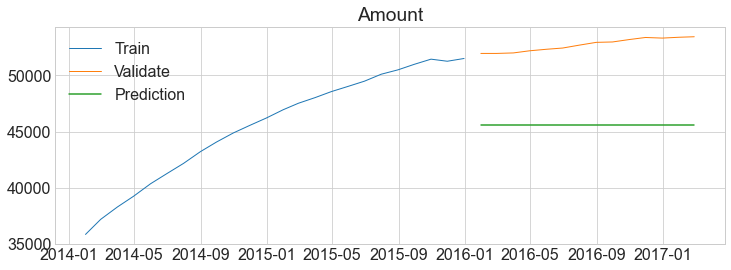

In [33]:
for col in train.columns:
    plot_and_eval(col)

In [34]:
# append to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0


### Moving Average

In [35]:
period = 3

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
rolling_amount = round(train['Amount'].rolling(period).mean()[-1], 2)


In [36]:
period=3
train['Amount'].rolling(period).mean()[-1]

51403.333333333336

In [37]:
yhat_df = make_predictions(rolling_amount)
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,51403.33
2016-02-29,51403.33
2016-03-31,51403.33
2016-04-30,51403.33
2016-05-31,51403.33


Amount -- RMSE: 1436


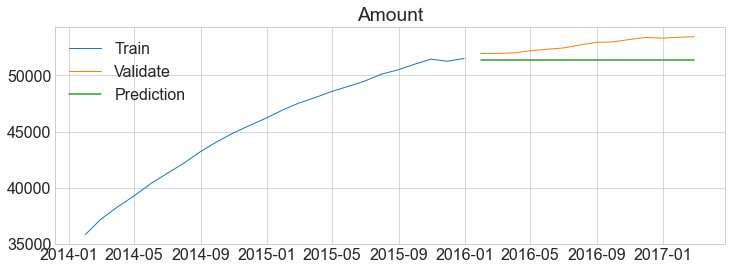

In [38]:
for col in train.columns:
    plot_and_eval(col)

In [39]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '3month_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0
2,3month_moving_avg,Amount,1436.0


### Holt's Linear Trend

Amount 



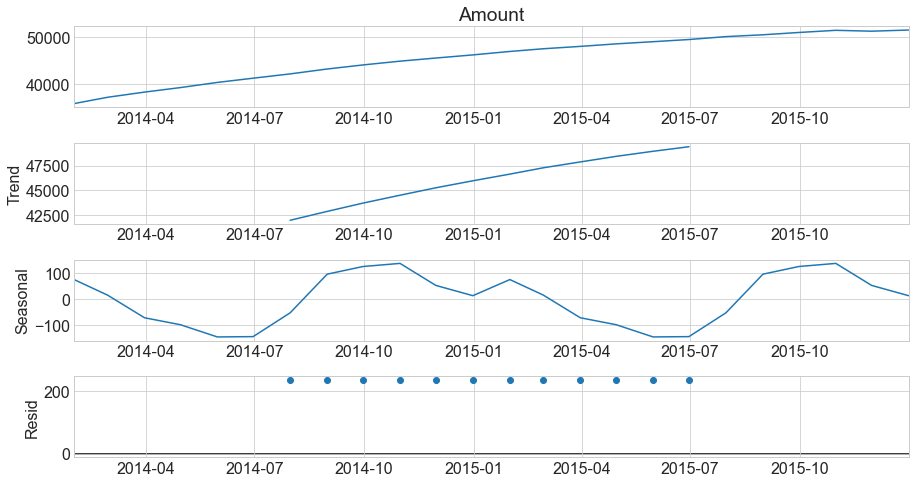

In [40]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
plt.show()

In [41]:
col = 'Amount' 
model = Holt(train[col], exponential=False, damped=True)
model = model.fit(optimized=True)

In [42]:
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [43]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [44]:
yhat_df

,Amount
Month_Invoiced,
2016-01-31,51748.62
2016-02-29,51962.00
2016-03-31,52173.35
2016-04-30,52382.69
2016-05-31,52590.04
2016-06-30,52795.43
2016-07-31,52998.86
2016-08-31,53200.36
2016-09-30,53399.95


Amount -- RMSE: 456


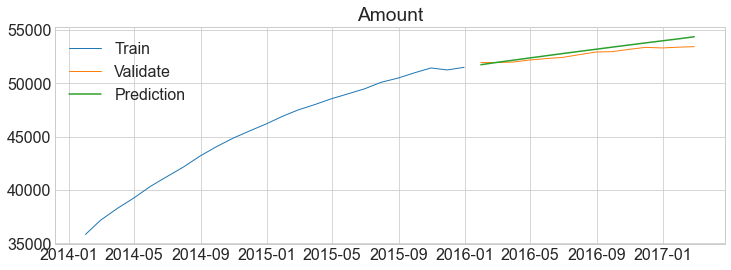

In [45]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [46]:
eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [47]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0
1,simple_average,Amount,7181.0
2,3month_moving_avg,Amount,1436.0
3,holts_optimized,Amount,456.0


### Evaluate on test data

In [48]:
model = Holt(train[col], exponential=False, damped=True)
model = model.fit(optimized=True)
test_prediction = model.predict(start = test.index[0],
                              end = test.index[-1])

In [49]:
rmse = round(sqrt(mean_squared_error(test['Amount'], test_prediction)), 0)
rmse


1761.0

### plot on test data

Amount -- RMSE: 1761


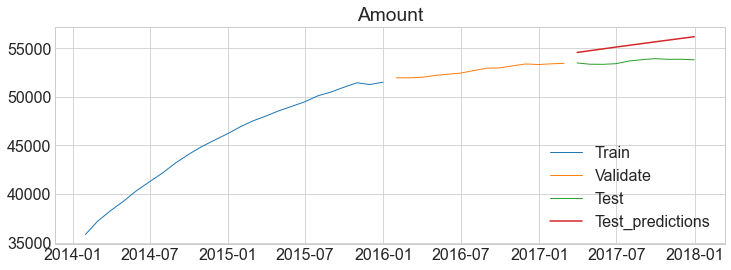

In [50]:
# set figure size
plt.figure(figsize = (12,4))

# plot target variable in train
plt.plot(train['Amount'], label='Train', linewidth=1)

# plot target variable in validate
plt.plot(validate['Amount'], label='Validate', linewidth=1)

# plot target variable in validate
plt.plot(test['Amount'], label='Test', linewidth=1)

# plot yhat_df 'predictions' on target variable
plt.plot(test_prediction, label='Test_predictions')

#set title
plt.title('Amount')


#print
print('Amount', '-- RMSE: {:.0f}'.format(rmse))
plt.legend()
plt.show()